sampling centers

In [15]:
import warnings

# https://stackoverflow.com/a/9134842/5885810     (supress warning by message)
warnings.filterwarnings('ignore', message='You will likely lose important projection '\
                        'information when converting to a PROJ string from another format')

from pointpats import random as pran
import geopandas as gpd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyproj as pp

In [137]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

In [5]:
SHP_FILE = '../model_input/HAD_basin.shp'                # catchment shape-file in WGS84
BUFFER    =     21097.5                                   # in meters! -> buffer distance (out of the HAD)

# OGC-WKT for HAD [taken from https://epsg.io/42106]
WKT_OGC = 'PROJCS["WGS84_/_Lambert_Azim_Mozambique",'\
    'GEOGCS["unknown",'\
        'DATUM["unknown",'\
            'SPHEROID["Normal Sphere (r=6370997)",6370997,0]],'\
        'PRIMEM["Greenwich",0,'\
            'AUTHORITY["EPSG","8901"]],'\
        'UNIT["degree",0.0174532925199433,'\
            'AUTHORITY["EPSG","9122"]]],'\
    'PROJECTION["Lambert_Azimuthal_Equal_Area"],'\
    'PARAMETER["latitude_of_center",5],'\
    'PARAMETER["longitude_of_center",20],'\
    'PARAMETER["false_easting",0],'\
    'PARAMETER["false_northing",0],'\
    'UNIT["metre",1,'\
        'AUTHORITY["EPSG","9001"]],'\
    'AXIS["Easting",EAST],'\
    'AXIS["Northing",NORTH],'\
    'AUTHORITY["EPSG","42106"]]'


In [6]:
wtrwgs = gpd.read_file( SHP_FILE )
# transform it into EPSG:42106 & make the buffer    # this code does NOT work!
# https://gis.stackexchange.com/a/328276/127894     (geo series into gpd)
wtrshd = wtrwgs.to_crs( crs = WKT_OGC )          # //epsg.io/42106.wkt
BUFFRX = gpd.GeoDataFrame( geometry=wtrshd.buffer( BUFFER ) )#.to_crs(epsg=4326)



In [7]:
print( BUFFRX )



                                            geometry
0  POLYGON ((1496219.170 -52287.662, 1496224.965 ...


In [26]:
print( BUFFRX.bounds )



           minx          miny          maxx          maxy
0  1.330005e+06 -1.189565e+06  3.388498e+06  1.178825e+06


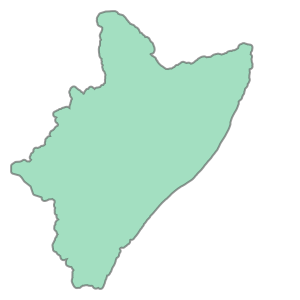

In [9]:

BUFFRX.geometry.xs(0)



In [10]:
CENTS = pran.poisson( BUFFRX.geometry.xs(0), size=666 )

print( CENTS )

[[2632579.7848637   628449.77367291]
 [1683463.75088608 -390821.96238239]
 [2324373.07134279   60577.72732627]
 ...
 [2402131.41194844 -708912.39961235]
 [2126769.73855548  368855.86211432]
 [3163146.03262095  468870.64366501]]


In [16]:
# you wanna PLOT the STORM CENTRES??

crs_had = pp.CRS.from_wkt( WKT_OGC ).to_proj4()
print( crs_had )

+proj=laea +lat_0=5 +lon_0=20 +x_0=0 +y_0=0 +ellps=sphere +units=m +no_defs +type=crs


C:\Users\manuel\miniconda3\envs\py39\lib\site-packages\pyproj\crs\crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


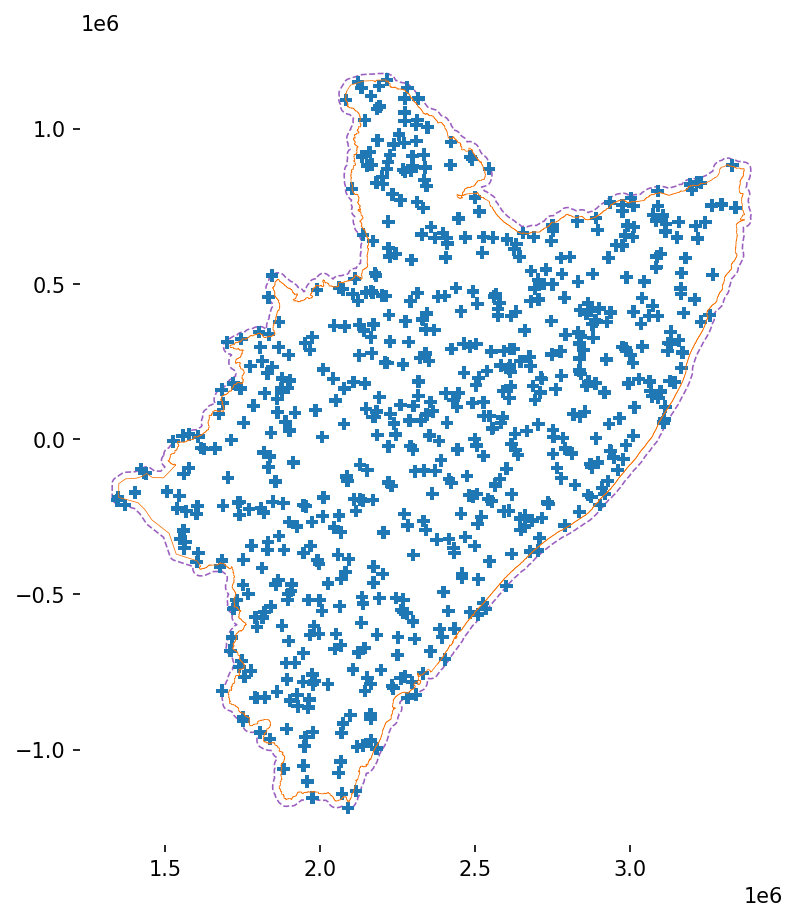

In [70]:
fig = plt.figure(figsize=(7,7), dpi=150)
ax = plt.axes( )
# ax.set_aspect(aspect='equal')
for spine in ax.spines.values(): spine.set_edgecolor(None)
BUFFRX.plot(edgecolor='xkcd:amethyst', alpha=1., zorder=2, linewidth=.77, ls='dashed', facecolor='None', ax=ax)
plt.scatter(CENTS[:,0], CENTS[:,1], marker='P', s=37, edgecolors='none', zorder=3)
wtrshd.plot(edgecolor='xkcd:orange', alpha=1., zorder=4, linewidth=.37, ls='solid', facecolor='None', ax=ax)
plt.show()

C:\Users\manuel\miniconda3\envs\py39\lib\site-packages\pyproj\crs\crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


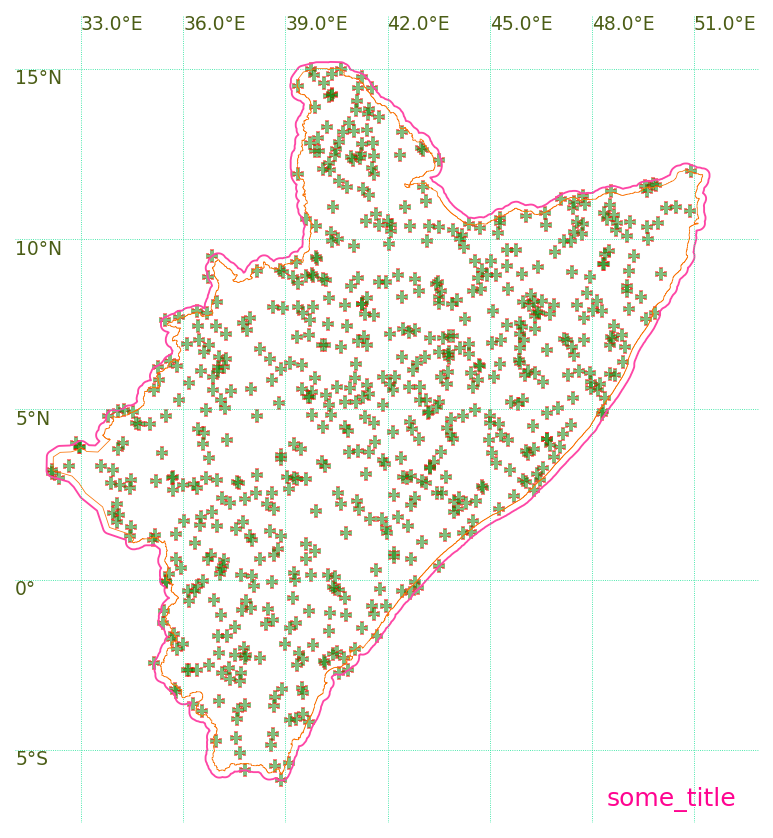

<Figure size 640x480 with 0 Axes>

In [156]:
# you wanna PLOT the STORM CENTRES??

crs_had = pp.CRS.from_wkt( WKT_OGC ).to_proj4()
car_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=5, central_longitude=20, false_easting=0, false_northing=0, globe=None)
lims = BUFFRX.bounds.iloc[0].to_dict()
difs = dict(x=abs(lims['maxx'] -lims['minx']), y=abs(lims['maxy'] -lims['miny']))
offs = 0.05 # in percentage


fig = plt.figure(figsize=(7,7), dpi=150)
# fig.tight_layout(pad=0)  # doesn't do shit here (maybe in the outxporting)

# ax = plt.axes(projection=ccrs.epsg(42106)) # this EPSG code doesn't officially exist!
# ax = plt.axes(projection=ccrs.Projection( crs_had )) # this gives you headaches
# ax = plt.axes( projection=car_crs ) # -> didn't create grid for this proj
ax = plt.axes( projection=ccrs.PlateCarree() )

ax.set_aspect(aspect='equal')
ax.spines['geo'].set_visible( False )
ax.xlabels_top = ax.ylabels_right = False  #;  gl.xlines = False

# 'eqc' potentially means that the system is PlateCarree [otherwise the following block won't work']
if ax.projection.proj4_params['proj'] == 'eqc':
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='xkcd:aqua green', linestyle='dotted', alpha=1.)
    gl.right_labels = False
    gl.bottom_labels = False

    gl.xformatter = LongitudeFormatter( direction_label='inout', degree_symbol='°',
        number_format='.1f', transform_precision=1e-08, dms=False, auto_hide=False )
    gl.yformatter = LatitudeFormatter( direction_label='inout', degree_symbol='°',
        number_format='.0f', transform_precision=1e-08, dms=False, auto_hide=False )
    gl.ylocator = LongitudeLocator( nbins=5, integer=True )
    # from matplotlib.ticker import FixedLocator
    # gl.ylocator = FixedLocator( [-4, 0, 4, 8, 12, 16] ) # for instance!
    
    gl.xlabel_style = {'size':9, 'color':'xkcd:army green', 'weight':'light', 'ha':'left'} #'visible':True
    gl.ylabel_style = {'size':9, 'color':'xkcd:army green', 'weight':'light', 'va':'top'}
    gl.xpadding = -0.1
    gl.ypadding = -0.1

ax.set_extent([lims['minx'] -difs['x'] *offs, lims['maxx'] +difs['x'] *offs,
               lims['miny'] -difs['y'] *offs, lims['maxy'] +difs['y'] *offs], crs=car_crs)

ax.add_geometries(BUFFRX.geometry.xs(0), edgecolor='xkcd:barbie pink', facecolor='none', linewidth=0.9, zorder=2, crs=car_crs)
ax.add_geometries(wtrshd.geometry.xs(0), edgecolor='xkcd:orange', facecolor='none', linewidth=.37, zorder=4, crs=car_crs)

plt.scatter(CENTS[:,0], CENTS[:,1], marker='P', s=37, edgecolors='red', lw=.003, alpha=.5, c='green', transform=car_crs)


# add time.stamp
ax.text(0.97, 0.03, 'some_title', color='xkcd:electric pink', fontsize=12, fontweight='normal',
    horizontalalignment='right', va='center', clip_on=True, transform=ax.transAxes)

plt.show()
plt.close()
plt.clf()